# Titanic Survivors Prediction

This is a project about predicting if a person would survive to the sinking of the Titanic.

This project will use an ensemble learning approach, which will include the following models:
1. Naive Bayes
2. Decision Trees
3. Support Vector Machines (SVM)
4. Logistic Regresion

The model will be the average of the four models described below.

## Loading Libraries

In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Titanic Data

The dataset for this project is called "Titanic" which include the following features:

| Variable	         | Definition	                              | Key                    |
|--------------------|--------------------------------------------|------------------------|
| Id                 | Passenger Identificator                    |                        |
| Name               | Passenger Name                             |                        |
| Age	             | Age in years                               |                        |
| SibSp              | # of siblings / spouses aboard the Titanic |                        |
| ParCh              | # of parents / children aboard the Titanic |                        |
| Ticket             | Ticket number	                          |                        |
| Fare               | Passenger fare                             |                        |
| Cabin              | Cabin number                               |                        |
| Embarked           | Port of Embarkation	                      |C = Cherbourg, Q = Queenstown, S = Southampton|
| Class              | Ticket class                               | Lower, Middle, Upper   |
| Sex                | Sex                                        |                        |
| Survived           | Survived                                   | N = No, Y = Yes        |

The variable we want to predict is **Survived** which is a binary feature taking values:
* N: Didn't survived
* Y: Survived

In [212]:
#Loading dataset "Titanic"
titanic = pd.read_csv('data_titanic_proyecto.csv')
titanic.columns = ['Id', 'Name', 'Age', 'SibSp', 'ParCh', 'Ticket', 'Fare', 'Cabin', 'Embarked', 
                   'Class', 'Sex', 'Survived']

In [213]:
titanic.head()

,Id,Name,Age,SibSp,ParCh,Ticket,Fare,Cabin,Embarked,Class,Sex,Survived
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N


Now we're going to separate the data set into two:
* X: Contains all features that we're going to use in the model
* y: Contains the variable we want to predict

In [214]:
X = titanic.drop(['Name', 'Ticket', 'Cabin', 'Survived'], axis = 1)
y = pd.DataFrame(titanic['Survived'])
print('Number of rows for dataset X: ', X.shape[0], sep = '')
print('Number of rows for dataset y: ', y.shape[0], sep = '')

Number of rows for dataset X: 891
Number of rows for dataset y: 891


Check for NA values for each feature

In [215]:
total = X.isnull().sum().sort_values(ascending=False)
percent = (X.isnull().sum()/X.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Age,177,0.198653
Embarked,2,0.002245
Sex,0,0.000000
Class,0,0.000000
Fare,0,0.000000
ParCh,0,0.000000
SibSp,0,0.000000
Id,0,0.000000


## Feature Engineering: Part 1

### Dealing with NAs

For the column **Embarked** we will use a mode imputation. This means that the 2 missing values will get the mode for the whole column. In this case is **S: Southampton**

In [216]:
X['Embarked'].fillna(X['Embarked'].mode()[0], inplace=True)

For the column **Age** we'll use another approach: a linear model. But first, we need to change categorical features to numerical values. This is because the model will not contemplate ***string type*** tensors.

In [217]:
from sklearn import preprocessing

#Creating the label encoder
encoder = preprocessing.LabelEncoder()

#Converting string labels into numbers
embarked_code = encoder.fit_transform(np.array(X['Embarked']))
class_code = encoder.fit_transform(np.array(X['Class']))
sex_code = encoder.fit_transform(np.array(X['Sex']))
survived_code = encoder.fit_transform(np.array(y['Survived']))

Now that we have our codes for each category we can create the new columns in the data frame.

In [218]:
X['embarked_code'] = embarked_code
X['class_code'] = class_code
X['sex_code'] = sex_code
y['survived_code'] = survived_code

In [219]:
X.head()

,Id,Age,SibSp,ParCh,Fare,Embarked,Class,Sex,embarked_code,class_code,sex_code
0,1,22.0,1,0,7.2500,S,Lower,M,2,0,1
1,2,38.0,1,0,71.2833,C,Upper,F,0,2,0
2,3,26.0,0,0,7.9250,S,Lower,F,2,0,0
3,4,35.0,1,0,53.1000,S,Upper,F,2,2,0
4,5,35.0,0,0,8.0500,S,Lower,M,2,0,1


In [220]:
y.head()

,Survived,survived_code
0,N,0
1,Y,1
2,Y,1
3,Y,1
4,N,0


Now, we need to generate the linear model in order to find the missing values for the age. This linear model will take **Age** as the variable we want to predict, using the following features:
* Embarked
* Class
* Sex
* SibSp
* ParCh

In [221]:
#Loading the libraries and functions
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

In [222]:
def age_prediction(x,y):
    lm = LinearRegression()
    lm.fit(X=x, y=y)
    y_hat = lm.predict(x)
    error = (1/2*np.mean((y_hat-y)**2))
    
    #building df
    df_dict = {'Id': X.dropna().Id, 'y_hat': y_hat}
    df = pd.DataFrame(df_dict)
    return(lm.coef_, lm.intercept_, error, lm)

In [223]:
age_lm = age_prediction(X.dropna().drop(['Id', 'Embarked', 'Class', 'Sex', 'Age'], axis = 1), X['Age'].dropna())

Now that we have the linear model for the prediction of age in place, we'll predict the new values for **Age** in a new column called ***Age_lm***

In [224]:
X['age_lm'] = age_lm[3].predict(X.drop(['Id', 'Embarked', 'Class', 'Sex', 'Age'], axis = 1))
X['Age_LM'] = np.where(X['Age']>0, X['Age'], np.where(X['age_lm']>0, X['age_lm'], 1))
X = X.drop('age_lm', axis = 1)
X.head()

,Id,Age,SibSp,ParCh,Fare,Embarked,Class,Sex,embarked_code,class_code,sex_code,Age_LM
0,1,22.0,1,0,7.2500,S,Lower,M,2,0,1,22.0
1,2,38.0,1,0,71.2833,C,Upper,F,0,2,0,38.0
2,3,26.0,0,0,7.9250,S,Lower,F,2,0,0,26.0
3,4,35.0,1,0,53.1000,S,Upper,F,2,2,0,35.0
4,5,35.0,0,0,8.0500,S,Lower,M,2,0,1,35.0


Now we can check again the missing values

In [225]:
total = X.isnull().sum().sort_values(ascending=False)
percent = (X.isnull().sum()/X.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Age,177,0.198653
Age_LM,0,0.000000
sex_code,0,0.000000
class_code,0,0.000000
embarked_code,0,0.000000
Sex,0,0.000000
Class,0,0.000000
Embarked,0,0.000000
Fare,0,0.000000
ParCh,0,0.000000


We created a new column called **Age_LM** which contains no missing values. This will be our Age column from now on in every model.

Now, we need to scale the variables Age and Fare because they have different values. This will enhance our model.

In [226]:
X['Fare_Norm'] = preprocessing.normalize(np.array(X['Fare']).reshape(1, -1))[0]
X['Age_Norm'] = preprocessing.normalize(np.array(X['Age_LM']).reshape(1, -1))[0]
X['Age_Group'] = np.where(
    X['Age_LM']<=15,
    0,
    np.where(
        X['Age_LM']<=30,
        1,
        np.where(
            X['Age_LM']<=65,
            2,
            3
        )
    )
)
X['Fare_Group'] = np.where(
    X['Fare']<=10,
    0,
    np.where(
        X['Fare']<=20,
        1,
        np.where(
            X['Fare']<=30,
            2,
            3
        )
    )
)
X = X.drop(['Fare', 'Age_LM'], axis = 1)

## Train, Val, and Test Sets

We're going to split the dataset in three different sets:
* Train
* Validation (Val)
* Test

For these datsets, we'll use the following features:
1. Age_LM
2. SibSp
3. Parch
4. Fare
5. Embarked (code)
6. Class (code)
7. Sex (code)

And the variable we want to predict
1. Survived

In [387]:
#Loading the libraries and functions
from sklearn.model_selection import train_test_split

In [388]:
X_train, X_test, y_train, y_test = train_test_split(
    X.drop(['Id', 'Age', 'Embarked', 'Class', 'Sex'], axis=1), 
    y.drop('Survived', axis=1), 
    test_size=0.2, 
    random_state=17
)

In [389]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.2, 
    random_state=17
)

In [390]:
print('Number of rows in Train: ', len(X_train), ' (', round(100*len(X_train)/len(titanic),1), '%)', sep = '')
print('Number of rows in Val: ', len(X_val), ' (', round(100*len(X_val)/len(titanic),1), '%)', sep = '')
print('Number of rows in Test: ', len(X_test), ' (', round(100*len(X_test)/len(titanic),1), '%)', sep = '')

Number of rows in Train: 569 (63.9%)
Number of rows in Val: 143 (16.0%)
Number of rows in Test: 179 (20.1%)


## Exploration

### Histograms for numerical features and Survival

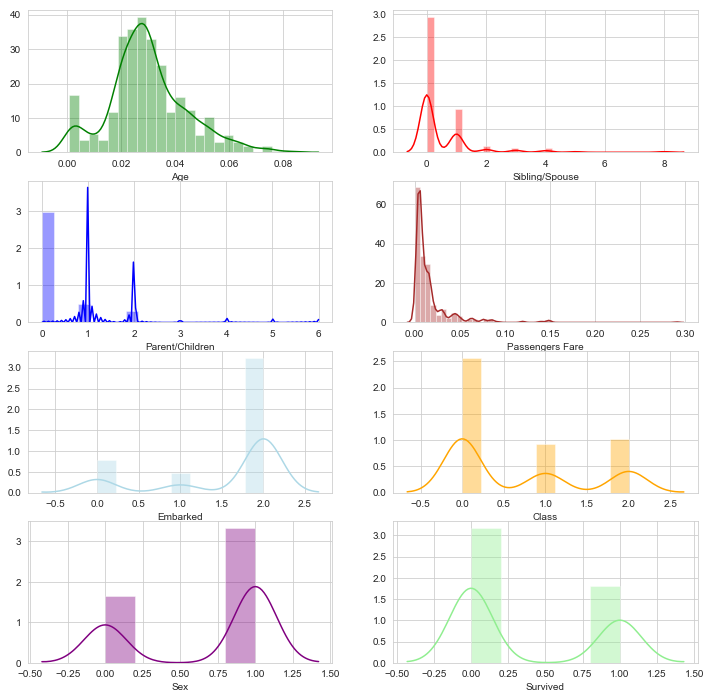

In [122]:
plt.figure(figsize=(12,12))
sns.set_style("whitegrid")
plt.subplot(4,2,1)
sns.distplot(X_train['Age_Norm'], color='green', axlabel='Age')
plt.subplot(4,2,2)
sns.distplot(X_train['SibSp'], color='red', axlabel='Sibling/Spouse')
plt.subplot(4,2,3)
sns.distplot(X_train['ParCh'], color='blue', axlabel='Parent/Children')
plt.subplot(4,2,4)
sns.distplot(X_train['Fare_Norm'], color='brown', axlabel='Passengers Fare')
plt.subplot(4,2,5)
sns.distplot(X_train['embarked_code'], color='lightblue', axlabel='Embarked')
plt.subplot(4,2,6)
sns.distplot(X_train['class_code'], color='orange', axlabel='Class')
plt.subplot(4,2,7)
sns.distplot(X_train['sex_code'], color='purple', axlabel='Sex')
plt.subplot(4,2,8)
sns.distplot(y_train['survived_code'], color='lightgreen', axlabel='Survived')

### Correlation of each feature and Survival

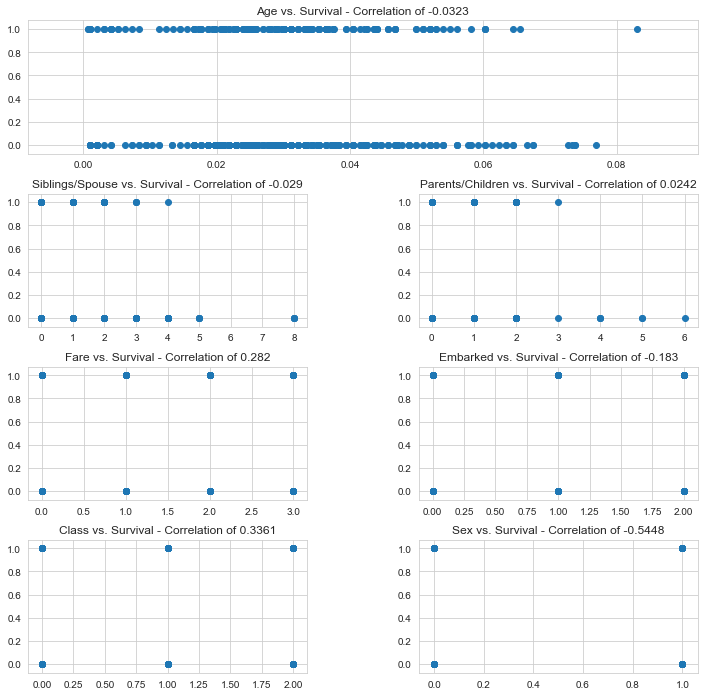

In [125]:
plt.figure(figsize=(12,12))
grid = plt.GridSpec(4, 2, wspace=0.4, hspace=0.3)
plt.subplot(grid[0, 0:])
plt.scatter(x = X_train['Age_Norm'], y = y_train['survived_code'])
plt.title('Age vs. Survival - Correlation of ' + 
          str(np.round(np.corrcoef(x = X_train['Age_Norm'], y = y_train['survived_code'])[0,1],4)))
plt.subplot(grid[1, 0])
plt.scatter(x = X_train['SibSp'], y = y_train['survived_code'])
plt.title('Siblings/Spouse vs. Survival - Correlation of ' + 
          str(np.round(np.corrcoef(x = X_train['SibSp'], y = y_train['survived_code'])[0,1],4)))
plt.subplot(grid[1, 1])
plt.scatter(x = X_train['ParCh'], y = y_train['survived_code'])
plt.title('Parents/Children vs. Survival - Correlation of ' + 
          str(np.round(np.corrcoef(x = X_train['ParCh'], y = y_train['survived_code'])[0,1],4)))
plt.subplot(grid[2, 0])
plt.scatter(x = X_train['Fare_Group'], y = y_train['survived_code'])
plt.title('Fare vs. Survival - Correlation of ' + 
          str(np.round(np.corrcoef(x = X_train['Fare_Group'], y = y_train['survived_code'])[0,1],4)))
plt.subplot(grid[2, 1])
plt.scatter(x = X_train['embarked_code'], y = y_train['survived_code'])
plt.title('Embarked vs. Survival - Correlation of ' + 
          str(np.round(np.corrcoef(x = X_train['embarked_code'], y = y_train['survived_code'])[0,1],4)))
plt.subplot(grid[3, 0])
plt.scatter(x = X_train['class_code'], y = y_train['survived_code'])
plt.title('Class vs. Survival - Correlation of ' + 
          str(np.round(np.corrcoef(x = X_train['class_code'], y = y_train['survived_code'])[0,1],4)))
plt.subplot(grid[3, 1])
plt.scatter(x = X_train['sex_code'], y = y_train['survived_code'])
plt.title('Sex vs. Survival - Correlation of ' + 
          str(np.round(np.corrcoef(x = X_train['sex_code'], y = y_train['survived_code'])[0,1],4)))
plt.show()

/anaconda3/envs/galileo_python/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


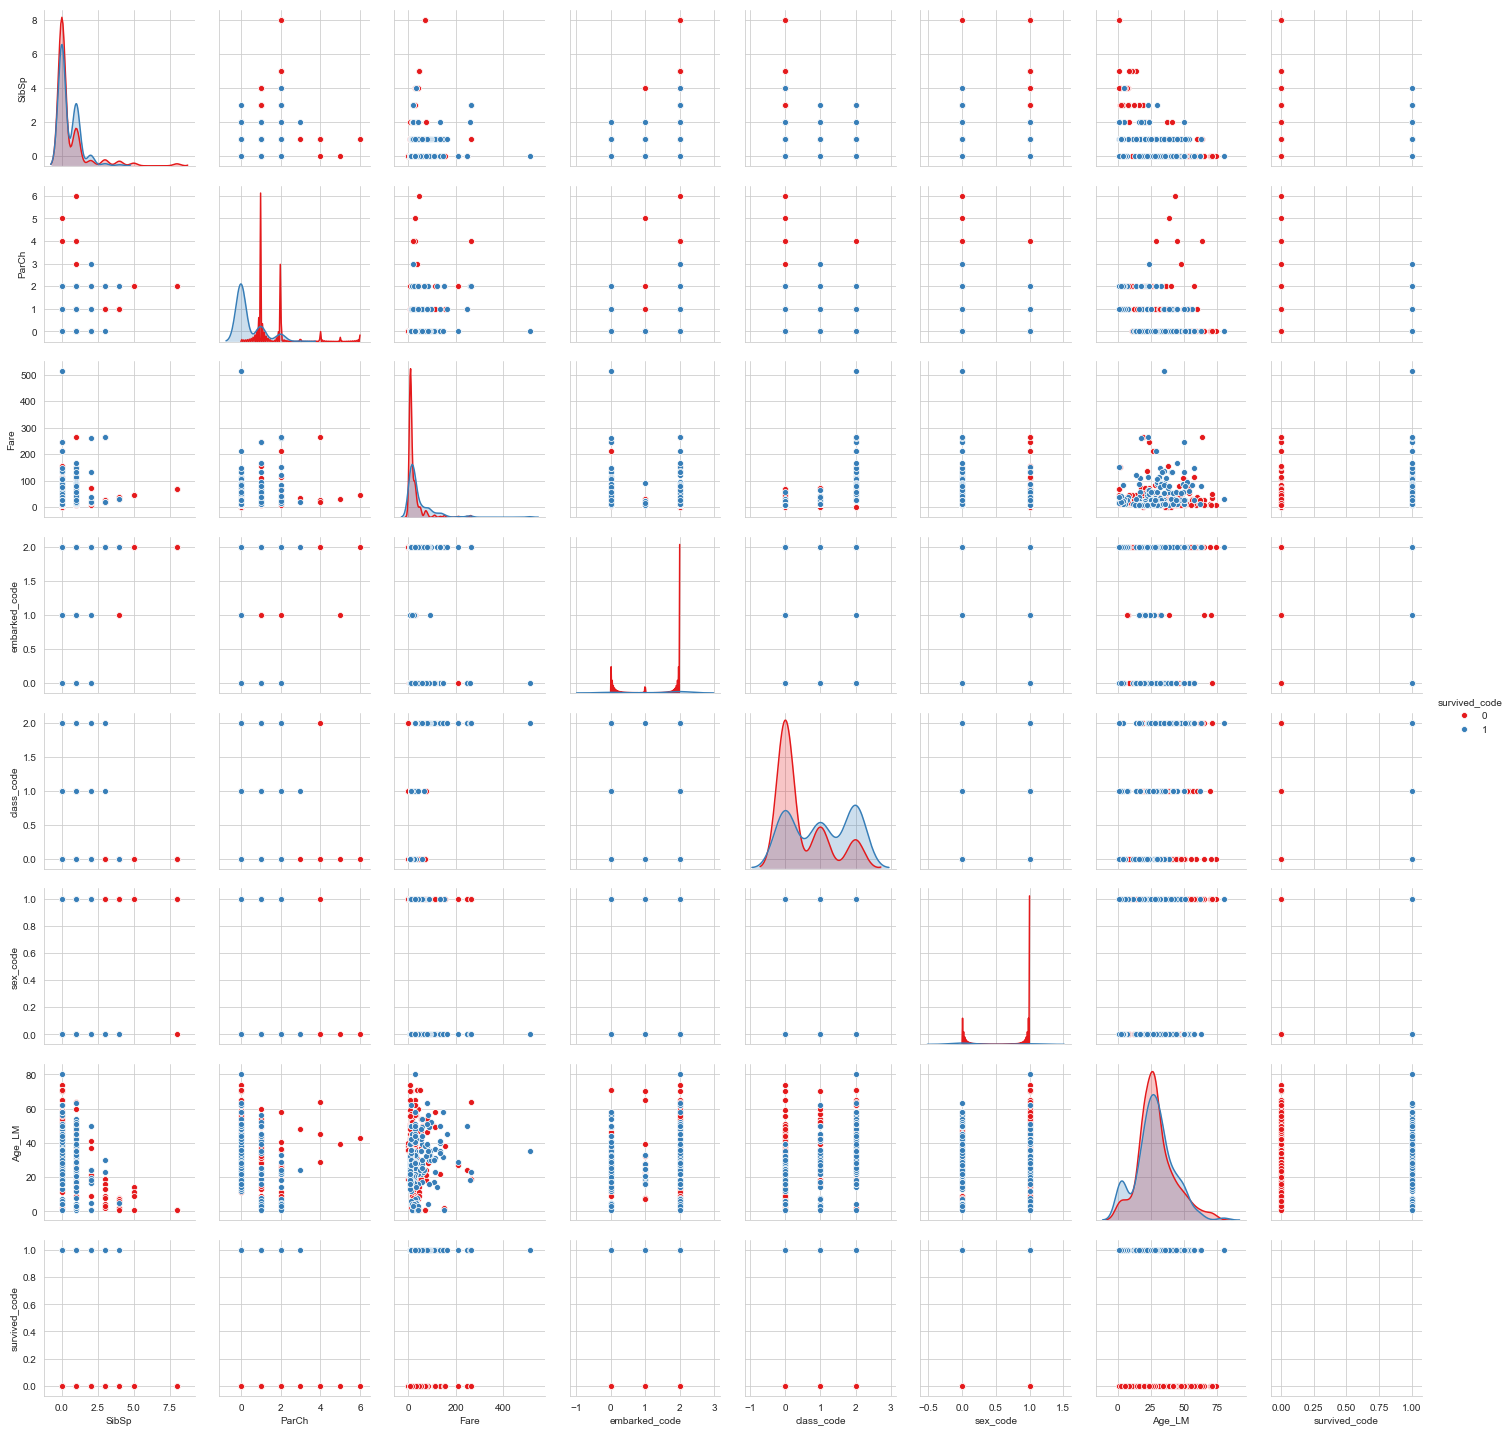

In [31]:
sns.pairplot(pd.merge(X_train, y_train, left_index = True, right_index = True),
             hue = 'survived_code',
             palette = 'Set1')

## Ensemble Learning

As mentioned before, this project will be based on Ensemble Learning. The models to evaluate will be:
1. Naive Bayes
2. Decision Trees
3. SVM
4. Logistic Regression

Each of these models will predict weather a **passenger survives** (which is the variable we want to predict) or not and the pick of the majority will be selected.

Also, we need to keep track of each model computed in the form of a log which will have the following model information:
* Model name
* Model description
* Model configuration
* Model results

In [55]:
log = pd.DataFrame(columns = ['Name', 'Description', 'Configuration', 'Results'])

## Model 1: Naive Bayes

First, we need to import a library for the model to work properly.

In [126]:
from itertools import product, chain
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

We need to create a new dataset that contains both X_train and y_train because this model of Naive Bayes requires that the predictor is in the input dataframe.

For this first model we're going to predict the survival of a passenger using the following features:
* ParCh
* Sex

### Defining the function

In [127]:
def naive_bayes(X_train, y_train, X_test, y_test, threshold, exp_name):
    
    global log
    
    if exp_name in log['Name'].unique():
        print('The experiment name is already in use. Please change to a name that is not in the following list: '
              + str(log['Name'].unique()))
        return(0,0)
    
    data = pd.concat([X_train, y_train], axis = 1)
    origin_col = data.drop('survived_code', axis = 1).columns
    l = data.drop('survived_code', axis = 1).values.T.tolist()
    key = pd.DataFrame(list(product(*l)), 
                       columns=data.columns[0:len(data.columns)-1])
    key = key.drop_duplicates()
    key = key.sort_values(by = data.columns[0])
    origin_len = len(key.columns)

    for i in range(0, origin_len):
        p = pd.DataFrame(np.array(data.groupby(key.columns[i]).size()/len(data)))
        p.reset_index(level = None, inplace = True)
        p.columns = [key.columns[i], 'p_'+key.columns[i]]
        key = pd.merge(key, p, how = 'left')

        ct = pd.crosstab(data['survived_code'], data[key.columns[i]]).apply(lambda r: r/r.sum(), axis=1).T
        ct.reset_index(level = None, inplace = True)
        ct.columns = [key.columns[i], 'pc_'+key.columns[i]+'_0', 'pc_'+key.columns[i]+'_1']
        key = pd.merge(key, ct, how = 'left')

    key['p_survived_0'] = np.array(data.groupby('survived_code').size()/len(data))[0]
    key['p_survived_1'] = np.array(data.groupby('survived_code').size()/len(data))[1]

    prob_0 = 1
    prob_1 = 1
    for i in range(0, origin_len):
        prob_0 *= ((key['pc_'+str(key.columns[i])+'_0']*key['p_survived_0'])/key['p_'+str(key.columns[i])])
        prob_1 *= ((key['pc_'+str(key.columns[i])+'_1']*key['p_survived_1'])/key['p_'+str(key.columns[i])])

    key['p_0'] = prob_0/(prob_0+prob_1)
    key['p_1'] = prob_1/(prob_0+prob_1)
    
    nb_pred = pd.merge(X_test, key, how = 'left')
    nb_pred['survived_code_pred'] = np.where(nb_pred['p_1'] > threshold, 1, 0)
    nb_pred = np.array(nb_pred['survived_code_pred'])
    
    nb_accuracy = accuracy_score(y_test, nb_pred)
    
    log_info = {
        'Name': exp_name,
        'Description': 'Naive Bayes Model for Titanic Survival Prediction',
        'Configuration': 'naive_bayes_threshold:' + str(threshold) + 
        '_reg:' + '_'.join(np.array(origin_col)),
        'Results': {
            'accuracy': nb_accuracy,
            'error': 1 - nb_accuracy,
            'precision': precision_score(y_test, nb_pred),
            'recall': recall_score(y_test, nb_pred),
            'f1-score': f1_score(y_test, nb_pred)
        }
    }
    log = log.append(log_info, ignore_index=True)
    
    return(nb_pred, log_info)

In [247]:
bayes = naive_bayes(X_train[['sex_code', 'ParCh']], 
                    y_train, 
                    X_val[['sex_code', 'ParCh']], 
                    y_val, 
                    threshold = 0.50, 
                    exp_name = 'exp_32')

### Model 1: Results

In [248]:
print('Accuracy in Validation Test: ', 
      round(100*bayes[1]['Results']['accuracy'], 2),
      '%', sep = '')

Accuracy in Validation Test: 80.42%


In [249]:
#Checking our Naive Bayes experiments
log

,Name,Description,Configuration,Results
0,exp_5,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_Age_Group,"{'accuracy': 0.7710280373831776, 'error': 0.22..."
1,exp_6,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_Age_Gro...,"{'accuracy': 0.7523364485981309, 'error': 0.24..."
2,exp_1,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_class_c...,"{'accuracy': 0.7383177570093458, 'error': 0.26..."
3,exp_2,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_class_c...,"{'accuracy': 0.7897196261682243, 'error': 0.21..."
4,exp_3,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.6_reg:sex_code_class_c...,"{'accuracy': 0.7383177570093458, 'error': 0.26..."
5,exp_4,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.4_reg:sex_code_class_c...,"{'accuracy': 0.7897196261682243, 'error': 0.21..."
6,exp_7,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_class_c...,"{'accuracy': 0.7897196261682243, 'error': 0.21..."
7,exp_8,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_embarke...,"{'accuracy': 0.7710280373831776, 'error': 0.22..."
8,exp_9,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_embarke...,"{'accuracy': 0.7902097902097902, 'error': 0.20..."
9,exp_10,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_class_code,"{'accuracy': 0.7762237762237763, 'error': 0.22..."


## Model 2: Decision Trees

First, we need to import the libraries

In [250]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.externals import joblib

Now, we're defining the model with a Decision Tree Classifier from **sklearn**. Then we're going to pass the ***fit*** function in order for the model to be trained.

In [258]:
def dtree_train(X_train, y_train, X_test, y_test, exp_name):
    
    global log
    
    if exp_name in log['Name'].unique():
        print('The experiment name is already in use. Please change to a name that is not in the following list: '
              + str(log['Name'].unique()))
        return(0,0)
    
    dtree = DecisionTreeClassifier()
    dtree.fit(X_train, y_train)
    #We need to predict if the passenger survived, so we pass the function predict to the Test set.
    dtree_pred = dtree.predict(X_test)
    dtree_accuracy = accuracy_score(y_test, dtree_pred)
    log_info = {
        'Name': exp_name,
        'Description': 'Decision Tree Model for Titanic Survival Prediction',
        'Configuration': 'dtree_reg:' + '_'.join(np.array(X_train.columns)),
        'Results': {
            'accuracy': dtree_accuracy,
            'error': 1 - dtree_accuracy,
            'precision': precision_score(y_test, dtree_pred),
            'recall': recall_score(y_test, dtree_pred),
            'f1-score': f1_score(y_test, dtree_pred)
        }
    }
    log = log.append(log_info, ignore_index=True)
    
    joblib.dump(dtree, log_info['Configuration']+'.pkl')
    
    return(dtree, dtree_pred, dtree_accuracy, log_info)

In [280]:
dtree = dtree_train(
    X_train.drop(['Age_Norm', 'Fare_Norm', 'Fare_Group'], axis = 1), 
    y_train, 
    X_val.drop(['Age_Norm', 'Fare_Norm', 'Fare_Group'], axis = 1), 
    y_val, 
    exp_name = 'dtree_experiment_6'
)

Now we can see the graph for the decision tree.

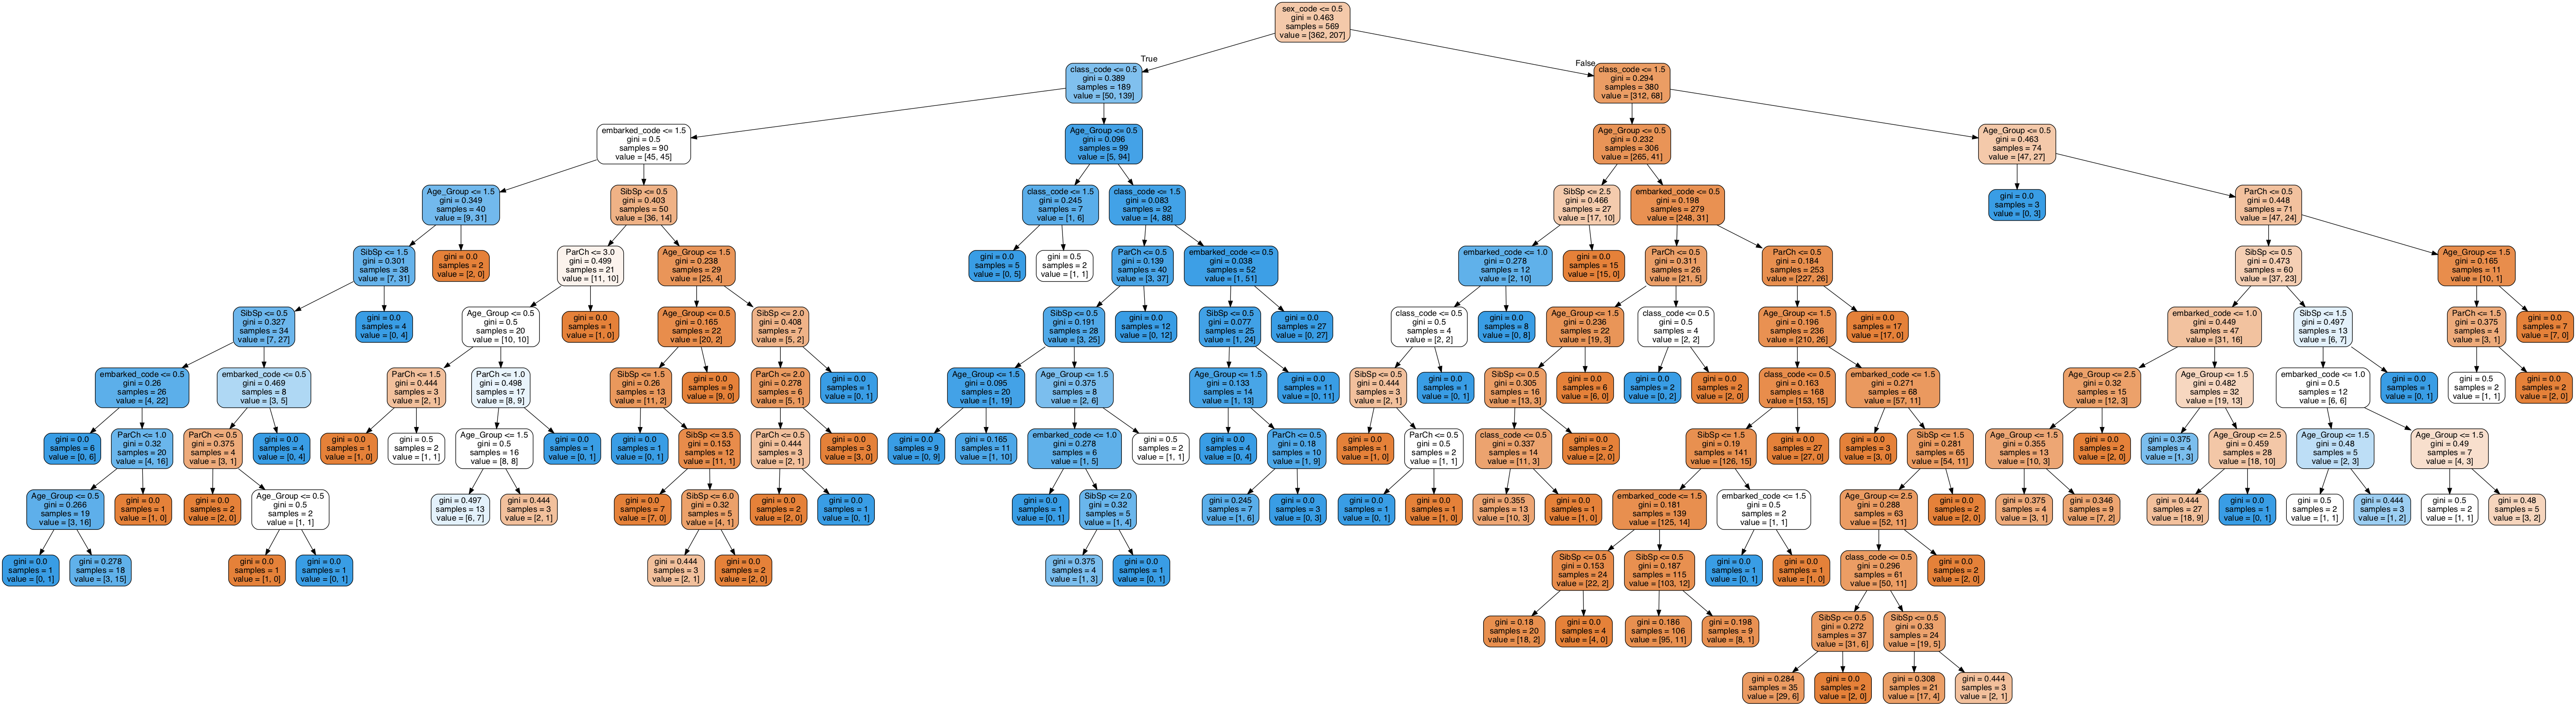

In [281]:
from IPython.display import Image 
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot

features = list(X_train.drop(['Age_Norm', 'Fare_Norm', 'Fare_Group'], axis = 1).columns[0:])

dot_data = StringIO()  
export_graphviz(
    dtree[0], 
    out_file = dot_data,
    feature_names = features,
    filled = True,
    rounded = True
)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

### Model 2: Results

In [282]:
print('Accuracy in Validation Test: ', 
      round(100*dtree[2], 2),
      '%', sep = '')

Accuracy in Validation Test: 80.42%


In [283]:
#Check the experiments log
log

,Name,Description,Configuration,Results
0,exp_5,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_Age_Group,"{'accuracy': 0.7710280373831776, 'error': 0.22..."
1,exp_6,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_Age_Gro...,"{'accuracy': 0.7523364485981309, 'error': 0.24..."
2,exp_1,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_class_c...,"{'accuracy': 0.7383177570093458, 'error': 0.26..."
3,exp_2,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_class_c...,"{'accuracy': 0.7897196261682243, 'error': 0.21..."
4,exp_3,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.6_reg:sex_code_class_c...,"{'accuracy': 0.7383177570093458, 'error': 0.26..."
5,exp_4,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.4_reg:sex_code_class_c...,"{'accuracy': 0.7897196261682243, 'error': 0.21..."
6,exp_7,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_class_c...,"{'accuracy': 0.7897196261682243, 'error': 0.21..."
7,exp_8,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_embarke...,"{'accuracy': 0.7710280373831776, 'error': 0.22..."
8,exp_9,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_embarke...,"{'accuracy': 0.7902097902097902, 'error': 0.20..."
9,exp_10,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_class_code,"{'accuracy': 0.7762237762237763, 'error': 0.22..."


Our second model using a decision tree, is giving us an acceptable accuracy. Now we can begin testing our next model, SVM.

## Model 3: Support Vector Machines (SVM)

First, we need to import the functions from **sklearn**

In [284]:
from sklearn.svm import SVC

Defining our SVM model

In [302]:
def svm(X_train, y_train, X_test, y_test, exp_name):
    
    global log
    
    if exp_name in log['Name'].unique():
        print('The experiment name is already in use. Please change to a name that is not in the following list: '
              + str(log['Name'].unique()))
        return(0,0)
    
    svm = SVC()
    svm.fit(X_train, y_train)
    #Now, we need to predict if the passenger survived with this new model, so we pass the function predict to the Validation set.
    svm_pred = svm.predict(X_test)
    svm_accuracy = accuracy_score(y_test, svm_pred)
    log_info = {
        'Name': exp_name,
        'Description': 'SVM Model for Titanic Survival Prediction',
        'Configuration': 'svm_reg:' + '_'.join(np.array(X_train.columns)),
        'Results': {
            'accuracy': svm_accuracy,
            'error': 1 - svm_accuracy,
            'precision': precision_score(y_test, svm_pred),
            'recall': recall_score(y_test, svm_pred),
            'f1-score': f1_score(y_test, svm_pred)
        }
    }
    log = log.append(log_info, ignore_index=True)
    
    joblib.dump(svm, log_info['Configuration']+'.pkl')
    
    return(svm, svm_pred, svm_accuracy, log_info)

In [309]:
svm_model = svm(
    X_train.drop(['Age_Norm', 'Fare_Norm'], axis = 1), 
    y_train, 
    X_val.drop(['Age_Norm', 'Fare_Norm'], axis = 1), 
    y_val, 
    exp_name = 'svm_experiment_5'
)

/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [310]:
print('Accuracy in Validation Test: ', 
      round(100*svm_model[2], 2),
      '%', sep = '')

Accuracy in Validation Test: 81.12%


In [311]:
log

,Name,Description,Configuration,Results
0,exp_5,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_Age_Group,"{'accuracy': 0.7710280373831776, 'error': 0.22..."
1,exp_6,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_Age_Gro...,"{'accuracy': 0.7523364485981309, 'error': 0.24..."
2,exp_1,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_class_c...,"{'accuracy': 0.7383177570093458, 'error': 0.26..."
3,exp_2,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_class_c...,"{'accuracy': 0.7897196261682243, 'error': 0.21..."
4,exp_3,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.6_reg:sex_code_class_c...,"{'accuracy': 0.7383177570093458, 'error': 0.26..."
5,exp_4,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.4_reg:sex_code_class_c...,"{'accuracy': 0.7897196261682243, 'error': 0.21..."
6,exp_7,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_class_c...,"{'accuracy': 0.7897196261682243, 'error': 0.21..."
7,exp_8,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_embarke...,"{'accuracy': 0.7710280373831776, 'error': 0.22..."
8,exp_9,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_embarke...,"{'accuracy': 0.7902097902097902, 'error': 0.20..."
9,exp_10,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_class_code,"{'accuracy': 0.7762237762237763, 'error': 0.22..."


Now, we'll use a grid search to find the best possible hyperparameters for SVM.

In [313]:
from sklearn.model_selection import GridSearchCV

In [328]:
def grid_svm(X_train, y_train, X_test, y_test, c, gamma, kernel, dfs, shrink, exp_name):
    
    global log
    
    if exp_name in log['Name'].unique():
        print('The experiment name is already in use. Please change to a name that is not in the following list: '
              + str(log['Name'].unique()))
        return(0,0)
    
    gridParameters = {
        'C': c, 
        'gamma': gamma, 
        'kernel': kernel, 
        'decision_function_shape': dfs,
        'shrinking': shrink
    }
    grid = GridSearchCV(SVC(), gridParameters, refit = True, verbose = 3)
    #Now that we have our grid search model in place, lets train it!
    grid.fit(X_train, y_train)
    grid_pred = grid.predict(X_test)
    grid_accuracy = accuracy_score(y_test, grid_pred)
    log_info = {
        'Name': exp_name,
        'Description': 'Grid SVM Model for Titanic Survival Prediction',
        'Configuration': 'grid_svm_C:' + 
        str(grid.best_params_['C']) + 
        '_gamma:' + str(grid.best_params_['gamma']) + 
        '_kernel:' + str(grid.best_params_['kernel']) + 
        '_reg:' + '_'.join(np.array(X_train.columns)),
        'Results': {
            'accuracy': grid_accuracy,
            'error': 1 - grid_accuracy,
            'precision': precision_score(y_test, grid_pred),
            'recall': recall_score(y_test, grid_pred),
            'f1-score': f1_score(y_test, grid_pred)
        }
    }
    log = log.append(log_info, ignore_index=True)
    
    joblib.dump(grid, log_info['Configuration']+'.pkl')
    
    return(grid, grid.best_params_, grid_accuracy, log_info)

In [331]:
grid_svm_model = grid_svm(
    X_train = X_train.drop(['Age_Norm', 'Fare_Norm'], axis = 1), 
    y_train = y_train, 
    X_test = X_val.drop(['Age_Norm', 'Fare_Norm'], axis = 1), 
    y_test = y_val, 
    c = [1, 0.25, 0.5, 0.75], 
    gamma = [1, 2, 3, 'auto'],
    kernel = ['linear', 'rbf'],
    dfs = ['ovo', 'ovr'],
    shrink = [True, False],
    exp_name = 'grid_svm_experiment_3'
)

/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1

Fitting 3 folds for each of 128 candidates, totalling 384 fits
[CV] C=1, decision_function_shape=ovo, gamma=1, kernel=linear, shrinking=True 
[CV]  C=1, decision_function_shape=ovo, gamma=1, kernel=linear, shrinking=True, score=0.7578947368421053, total=   0.0s
[CV] C=1, decision_function_shape=ovo, gamma=1, kernel=linear, shrinking=True 
[CV]  C=1, decision_function_shape=ovo, gamma=1, kernel=linear, shrinking=True, score=0.7894736842105263, total=   0.0s
[CV] C=1, decision_function_shape=ovo, gamma=1, kernel=linear, shrinking=True 
[CV]  C=1, decision_function_shape=ovo, gamma=1, kernel=linear, shrinking=True, score=0.8306878306878307, total=   0.0s
[CV] C=1, decision_function_shape=ovo, gamma=1, kernel=linear, shrinking=False 
[CV]  C=1, decision_function_shape=ovo, gamma=1, kernel=linear, shrinking=False, score=0.7578947368421053, total=   0.0s
[CV] C=1, decision_function_shape=ovo, gamma=1, kernel=linear, shrinking=False 
[CV]  C=1, decision_function_shape=ovo, gamma=1, kernel=lin

/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV]  C=1, decision_function_shape=ovr, gamma=1, kernel=rbf, shrinking=True, score=0.8157894736842105, total=   0.0s
[CV] C=1, decision_function_shape=ovr, gamma=1, kernel=rbf, shrinking=True 
[CV]  C=1, decision_function_shape=ovr, gamma=1, kernel=rbf, shrinking=True, score=0.8306878306878307, total=   0.0s
[CV] C=1, decision_function_shape=ovr, gamma=1, kernel=rbf, shrinking=False 
[CV]  C=1, decision_function_shape=ovr, gamma=1, kernel=rbf, shrinking=False, score=0.8, total=   0.0s
[CV] C=1, decision_function_shape=ovr, gamma=1, kernel=rbf, shrinking=False 
[CV]  C=1, decision_function_shape=ovr, gamma=1, kernel=rbf, shrinking=False, score=0.8157894736842105, total=   0.0s
[CV] C=1, decision_function_shape=ovr, gamma=1, kernel=rbf, shrinking=False 
[CV]  C=1, decision_function_shape=ovr, gamma=1, kernel=rbf, shrinking=False, score=0.8306878306878307, total=   0.0s
[CV] C=1, decision_function_shape=ovr, gamma=2, kernel=linear, shrinking=True 
[CV]  C=1, decision_function_shape=ovr, g

/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV]  C=1, decision_function_shape=ovr, gamma=3, kernel=rbf, shrinking=False, score=0.7883597883597884, total=   0.0s
[CV] C=1, decision_function_shape=ovr, gamma=auto, kernel=linear, shrinking=True 
[CV]  C=1, decision_function_shape=ovr, gamma=auto, kernel=linear, shrinking=True, score=0.7578947368421053, total=   0.0s
[CV] C=1, decision_function_shape=ovr, gamma=auto, kernel=linear, shrinking=True 
[CV]  C=1, decision_function_shape=ovr, gamma=auto, kernel=linear, shrinking=True, score=0.7894736842105263, total=   0.0s
[CV] C=1, decision_function_shape=ovr, gamma=auto, kernel=linear, shrinking=True 
[CV]  C=1, decision_function_shape=ovr, gamma=auto, kernel=linear, shrinking=True, score=0.8306878306878307, total=   0.0s
[CV] C=1, decision_function_shape=ovr, gamma=auto, kernel=linear, shrinking=False 
[CV]  C=1, decision_function_shape=ovr, gamma=auto, kernel=linear, shrinking=False, score=0.7578947368421053, total=   0.0s
[CV] C=1, decision_function_shape=ovr, gamma=auto, kernel=li

/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV]  C=0.25, decision_function_shape=ovo, gamma=2, kernel=linear, shrinking=False, score=0.7578947368421053, total=   0.0s
[CV] C=0.25, decision_function_shape=ovo, gamma=2, kernel=linear, shrinking=False 
[CV]  C=0.25, decision_function_shape=ovo, gamma=2, kernel=linear, shrinking=False, score=0.7894736842105263, total=   0.0s
[CV] C=0.25, decision_function_shape=ovo, gamma=2, kernel=linear, shrinking=False 
[CV]  C=0.25, decision_function_shape=ovo, gamma=2, kernel=linear, shrinking=False, score=0.8306878306878307, total=   0.0s
[CV] C=0.25, decision_function_shape=ovo, gamma=2, kernel=rbf, shrinking=True 
[CV]  C=0.25, decision_function_shape=ovo, gamma=2, kernel=rbf, shrinking=True, score=0.7052631578947368, total=   0.0s
[CV] C=0.25, decision_function_shape=ovo, gamma=2, kernel=rbf, shrinking=True 
[CV]  C=0.25, decision_function_shape=ovo, gamma=2, kernel=rbf, shrinking=True, score=0.7157894736842105, total=   0.0s
[CV] C=0.25, decision_function_shape=ovo, gamma=2, kernel=rbf, s

/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV]  C=0.25, decision_function_shape=ovo, gamma=auto, kernel=rbf, shrinking=True, score=0.7789473684210526, total=   0.0s
[CV] C=0.25, decision_function_shape=ovo, gamma=auto, kernel=rbf, shrinking=True 
[CV]  C=0.25, decision_function_shape=ovo, gamma=auto, kernel=rbf, shrinking=True, score=0.8052631578947368, total=   0.0s
[CV] C=0.25, decision_function_shape=ovo, gamma=auto, kernel=rbf, shrinking=True 
[CV]  C=0.25, decision_function_shape=ovo, gamma=auto, kernel=rbf, shrinking=True, score=0.8624338624338624, total=   0.0s
[CV] C=0.25, decision_function_shape=ovo, gamma=auto, kernel=rbf, shrinking=False 
[CV]  C=0.25, decision_function_shape=ovo, gamma=auto, kernel=rbf, shrinking=False, score=0.7789473684210526, total=   0.0s
[CV] C=0.25, decision_function_shape=ovo, gamma=auto, kernel=rbf, shrinking=False 
[CV]  C=0.25, decision_function_shape=ovo, gamma=auto, kernel=rbf, shrinking=False, score=0.8052631578947368, total=   0.0s
[CV] C=0.25, decision_function_shape=ovo, gamma=auto,

/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV]  C=0.25, decision_function_shape=ovr, gamma=2, kernel=rbf, shrinking=False, score=0.7157894736842105, total=   0.0s
[CV] C=0.25, decision_function_shape=ovr, gamma=2, kernel=rbf, shrinking=False 
[CV]  C=0.25, decision_function_shape=ovr, gamma=2, kernel=rbf, shrinking=False, score=0.7513227513227513, total=   0.0s
[CV] C=0.25, decision_function_shape=ovr, gamma=3, kernel=linear, shrinking=True 
[CV]  C=0.25, decision_function_shape=ovr, gamma=3, kernel=linear, shrinking=True, score=0.7578947368421053, total=   0.0s
[CV] C=0.25, decision_function_shape=ovr, gamma=3, kernel=linear, shrinking=True 
[CV]  C=0.25, decision_function_shape=ovr, gamma=3, kernel=linear, shrinking=True, score=0.7894736842105263, total=   0.0s
[CV] C=0.25, decision_function_shape=ovr, gamma=3, kernel=linear, shrinking=True 
[CV]  C=0.25, decision_function_shape=ovr, gamma=3, kernel=linear, shrinking=True, score=0.8306878306878307, total=   0.0s
[CV] C=0.25, decision_function_shape=ovr, gamma=3, kernel=linea

/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV]  C=0.5, decision_function_shape=ovo, gamma=1, kernel=linear, shrinking=False, score=0.8306878306878307, total=   0.0s
[CV] C=0.5, decision_function_shape=ovo, gamma=1, kernel=rbf, shrinking=True 
[CV]  C=0.5, decision_function_shape=ovo, gamma=1, kernel=rbf, shrinking=True, score=0.7894736842105263, total=   0.0s
[CV] C=0.5, decision_function_shape=ovo, gamma=1, kernel=rbf, shrinking=True 
[CV]  C=0.5, decision_function_shape=ovo, gamma=1, kernel=rbf, shrinking=True, score=0.7894736842105263, total=   0.0s
[CV] C=0.5, decision_function_shape=ovo, gamma=1, kernel=rbf, shrinking=True 
[CV]  C=0.5, decision_function_shape=ovo, gamma=1, kernel=rbf, shrinking=True, score=0.8412698412698413, total=   0.0s
[CV] C=0.5, decision_function_shape=ovo, gamma=1, kernel=rbf, shrinking=False 
[CV]  C=0.5, decision_function_shape=ovo, gamma=1, kernel=rbf, shrinking=False, score=0.7894736842105263, total=   0.0s
[CV] C=0.5, decision_function_shape=ovo, gamma=1, kernel=rbf, shrinking=False 
[CV]  C=

/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV]  C=0.5, decision_function_shape=ovo, gamma=3, kernel=rbf, shrinking=True, score=0.7684210526315789, total=   0.0s
[CV] C=0.5, decision_function_shape=ovo, gamma=3, kernel=rbf, shrinking=True 
[CV]  C=0.5, decision_function_shape=ovo, gamma=3, kernel=rbf, shrinking=True, score=0.7883597883597884, total=   0.0s
[CV] C=0.5, decision_function_shape=ovo, gamma=3, kernel=rbf, shrinking=False 
[CV]  C=0.5, decision_function_shape=ovo, gamma=3, kernel=rbf, shrinking=False, score=0.7368421052631579, total=   0.0s
[CV] C=0.5, decision_function_shape=ovo, gamma=3, kernel=rbf, shrinking=False 
[CV]  C=0.5, decision_function_shape=ovo, gamma=3, kernel=rbf, shrinking=False, score=0.7684210526315789, total=   0.0s
[CV] C=0.5, decision_function_shape=ovo, gamma=3, kernel=rbf, shrinking=False 
[CV]  C=0.5, decision_function_shape=ovo, gamma=3, kernel=rbf, shrinking=False, score=0.7883597883597884, total=   0.0s
[CV] C=0.5, decision_function_shape=ovo, gamma=auto, kernel=linear, shrinking=True 
[CV

/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV]  C=0.5, decision_function_shape=ovr, gamma=1, kernel=rbf, shrinking=False, score=0.7894736842105263, total=   0.0s
[CV] C=0.5, decision_function_shape=ovr, gamma=1, kernel=rbf, shrinking=False 
[CV]  C=0.5, decision_function_shape=ovr, gamma=1, kernel=rbf, shrinking=False, score=0.8412698412698413, total=   0.0s
[CV] C=0.5, decision_function_shape=ovr, gamma=2, kernel=linear, shrinking=True 
[CV]  C=0.5, decision_function_shape=ovr, gamma=2, kernel=linear, shrinking=True, score=0.7578947368421053, total=   0.0s
[CV] C=0.5, decision_function_shape=ovr, gamma=2, kernel=linear, shrinking=True 
[CV]  C=0.5, decision_function_shape=ovr, gamma=2, kernel=linear, shrinking=True, score=0.7894736842105263, total=   0.0s
[CV] C=0.5, decision_function_shape=ovr, gamma=2, kernel=linear, shrinking=True 
[CV]  C=0.5, decision_function_shape=ovr, gamma=2, kernel=linear, shrinking=True, score=0.8306878306878307, total=   0.0s
[CV] C=0.5, decision_function_shape=ovr, gamma=2, kernel=linear, shrinki

/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV]  C=0.5, decision_function_shape=ovr, gamma=auto, kernel=linear, shrinking=False, score=0.8306878306878307, total=   0.0s
[CV] C=0.5, decision_function_shape=ovr, gamma=auto, kernel=rbf, shrinking=True 
[CV]  C=0.5, decision_function_shape=ovr, gamma=auto, kernel=rbf, shrinking=True, score=0.7789473684210526, total=   0.0s
[CV] C=0.5, decision_function_shape=ovr, gamma=auto, kernel=rbf, shrinking=True 
[CV]  C=0.5, decision_function_shape=ovr, gamma=auto, kernel=rbf, shrinking=True, score=0.8052631578947368, total=   0.0s
[CV] C=0.5, decision_function_shape=ovr, gamma=auto, kernel=rbf, shrinking=True 
[CV]  C=0.5, decision_function_shape=ovr, gamma=auto, kernel=rbf, shrinking=True, score=0.8835978835978836, total=   0.0s
[CV] C=0.5, decision_function_shape=ovr, gamma=auto, kernel=rbf, shrinking=False 
[CV]  C=0.5, decision_function_shape=ovr, gamma=auto, kernel=rbf, shrinking=False, score=0.7789473684210526, total=   0.0s
[CV] C=0.5, decision_function_shape=ovr, gamma=auto, kernel=

/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV]  C=0.75, decision_function_shape=ovo, gamma=2, kernel=rbf, shrinking=False, score=0.8148148148148148, total=   0.0s
[CV] C=0.75, decision_function_shape=ovo, gamma=3, kernel=linear, shrinking=True 
[CV]  C=0.75, decision_function_shape=ovo, gamma=3, kernel=linear, shrinking=True, score=0.7578947368421053, total=   0.0s
[CV] C=0.75, decision_function_shape=ovo, gamma=3, kernel=linear, shrinking=True 
[CV]  C=0.75, decision_function_shape=ovo, gamma=3, kernel=linear, shrinking=True, score=0.7894736842105263, total=   0.0s
[CV] C=0.75, decision_function_shape=ovo, gamma=3, kernel=linear, shrinking=True 
[CV]  C=0.75, decision_function_shape=ovo, gamma=3, kernel=linear, shrinking=True, score=0.8306878306878307, total=   0.0s
[CV] C=0.75, decision_function_shape=ovo, gamma=3, kernel=linear, shrinking=False 
[CV]  C=0.75, decision_function_shape=ovo, gamma=3, kernel=linear, shrinking=False, score=0.7578947368421053, total=   0.0s
[CV] C=0.75, decision_function_shape=ovo, gamma=3, kernel

/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV]  C=0.75, decision_function_shape=ovr, gamma=1, kernel=rbf, shrinking=True, score=0.8412698412698413, total=   0.0s
[CV] C=0.75, decision_function_shape=ovr, gamma=1, kernel=rbf, shrinking=False 
[CV]  C=0.75, decision_function_shape=ovr, gamma=1, kernel=rbf, shrinking=False, score=0.8052631578947368, total=   0.0s
[CV] C=0.75, decision_function_shape=ovr, gamma=1, kernel=rbf, shrinking=False 
[CV]  C=0.75, decision_function_shape=ovr, gamma=1, kernel=rbf, shrinking=False, score=0.8105263157894737, total=   0.0s
[CV] C=0.75, decision_function_shape=ovr, gamma=1, kernel=rbf, shrinking=False 
[CV]  C=0.75, decision_function_shape=ovr, gamma=1, kernel=rbf, shrinking=False, score=0.8412698412698413, total=   0.0s
[CV] C=0.75, decision_function_shape=ovr, gamma=2, kernel=linear, shrinking=True 
[CV]  C=0.75, decision_function_shape=ovr, gamma=2, kernel=linear, shrinking=True, score=0.7578947368421053, total=   0.0s
[CV] C=0.75, decision_function_shape=ovr, gamma=2, kernel=linear, shrink

/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV]  C=0.75, decision_function_shape=ovr, gamma=auto, kernel=linear, shrinking=True, score=0.7578947368421053, total=   0.0s
[CV] C=0.75, decision_function_shape=ovr, gamma=auto, kernel=linear, shrinking=True 
[CV]  C=0.75, decision_function_shape=ovr, gamma=auto, kernel=linear, shrinking=True, score=0.7894736842105263, total=   0.0s
[CV] C=0.75, decision_function_shape=ovr, gamma=auto, kernel=linear, shrinking=True 
[CV]  C=0.75, decision_function_shape=ovr, gamma=auto, kernel=linear, shrinking=True, score=0.8306878306878307, total=   0.0s
[CV] C=0.75, decision_function_shape=ovr, gamma=auto, kernel=linear, shrinking=False 
[CV]  C=0.75, decision_function_shape=ovr, gamma=auto, kernel=linear, shrinking=False, score=0.7578947368421053, total=   0.0s
[CV] C=0.75, decision_function_shape=ovr, gamma=auto, kernel=linear, shrinking=False 
[CV]  C=0.75, decision_function_shape=ovr, gamma=auto, kernel=linear, shrinking=False, score=0.7894736842105263, total=   0.0s
[CV] C=0.75, decision_func

/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/galileo_python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d arr

### Model 3: Results

In [332]:
print('Accuracy in Validation Test: ', 
      round(100*grid_svm_model[2], 2),
      '%', sep = '')

Accuracy in Validation Test: 81.12%


In [333]:
#Check the experiments log
log

,Name,Description,Configuration,Results
0,exp_5,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_Age_Group,"{'accuracy': 0.7710280373831776, 'error': 0.22..."
1,exp_6,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_Age_Gro...,"{'accuracy': 0.7523364485981309, 'error': 0.24..."
2,exp_1,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_class_c...,"{'accuracy': 0.7383177570093458, 'error': 0.26..."
3,exp_2,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_class_c...,"{'accuracy': 0.7897196261682243, 'error': 0.21..."
4,exp_3,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.6_reg:sex_code_class_c...,"{'accuracy': 0.7383177570093458, 'error': 0.26..."
5,exp_4,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.4_reg:sex_code_class_c...,"{'accuracy': 0.7897196261682243, 'error': 0.21..."
6,exp_7,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_class_c...,"{'accuracy': 0.7897196261682243, 'error': 0.21..."
7,exp_8,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_embarke...,"{'accuracy': 0.7710280373831776, 'error': 0.22..."
8,exp_9,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_embarke...,"{'accuracy': 0.7902097902097902, 'error': 0.20..."
9,exp_10,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_class_code,"{'accuracy': 0.7762237762237763, 'error': 0.22..."


Our accuracy improved from the plain model to a grid search model. Now we can go ahead and run model 3, Naive Bayes.

## Model 4: Logistic Regression

### Loading Tensorflow

In [334]:
import tensorflow as tf

Defining the function for the logistic regression

In [409]:
def logistic_model(epochs, lr, beta, batch, x_model, y_model, W_model, x_test, y_test, b_model, k, exp_name):
    
    tf.reset_default_graph()
    
    #Hyperparameters
    epochs = epochs #parameter of the function
    lr = lr #parameter of the function
    
    #Learnable parameters
    W = tf.Variable(W_model, name = 'W')
    b = tf.Variable(b_model, name = 'b')

    #Other parameters
    k = k #parameter of the function: prints every k
    batch_size = batch
    m = x_model.shape[1] #parameter of the function for the number of columns of matrix x
    y_col = y_model.shape[1] #parameter of the function for the number of columns of matrix y
    beta = beta
    
    #Model variables
    X = tf.placeholder('float64', name = 'X', shape = [None, m])
    Y = tf.placeholder('float64', name = 'Y', shape = [None, y_col])
    
    #Hypothesis
    with tf.name_scope('Hypothesis'):
        logits = tf.add(tf.matmul(X, W, name = 'Matrix_Product'), b, name = 'Logits')
        y_hat = tf.nn.softmax(logits, name = 'Hypothesis_Softmax')
    
    #Cost Function
    with tf.name_scope('Cost_Function'):
        CE = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_hat), reduction_indices=[1]), name = 'CrossEntropy')
        reg = tf.nn.l2_loss(W, name = 'Regularization')
        error = tf.reduce_mean(tf.add(CE, beta*reg))
    
    #Gradient Descent
    with tf.name_scope('Gradient'):
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(error)
    
    #For accuracy
    with tf.name_scope('Accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(Y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    #Creating error summaries
    error_summary = tf.summary.scalar(name = 'Error_Summary', tensor = error)
    accuracy_summary = tf.summary.scalar(name = 'Accuracy_Summary', tensor = accuracy)
    
    graph_dir = (
        './graphs/graph_epochs='+str(epochs)+
        '_lr='+str(lr)+
        '_beta='+str(beta)+
        '_batch='+str(batch)
    )
    
    with tf.Session() as sess:
        
        tf.initialize_all_variables().run()
        print('Variables successfully initialized')
        
        writer = tf.summary.FileWriter(graph_dir, sess.graph)
        print('Directory created in', graph_dir)
        
        for epoch in range(epochs):
            
            forBatch = (epoch * batch_size) % (X_train.shape[0] - batch_size)
            #print(forBatch)
            feed_dict = {X : X_train[forBatch:(forBatch+batch_size)], 
                         Y : y_model[forBatch:(forBatch+batch_size)]}
            
            feed_dict_val = {X : x_test, 
                             Y : y_test}

            sess.run(optimizer, feed_dict)

            if (epoch+1)%k == 0:

                e,a = sess.run([error, accuracy], feed_dict)
                a_val = sess.run(accuracy, feed_dict_val)
                
                #running the summaries
                e_summary = sess.run(error_summary, feed_dict)
                a_summary = sess.run(accuracy_summary, feed_dict)
                writer.add_summary(e_summary, epoch)
                writer.add_summary(a_summary, epoch)
                
                print('Epoch = ', epoch+1, 
                      ': error = ', round(e,2), 
                      ', train accuracy = ', '{0:.2%}'.format(a),
                      ', val accuracy = ', '{0:.2%}'.format(a_val), sep = '')
        writer.close()
        
        log_info = {
            'Name': exp_name,
            'Description': 'Logistic Regression Model for Titanic Survival Prediction',
            'Configuration': 'log_reg_epochs:' + str(epochs) + 
            '_lr:' + str(lr) + 
            '_beta:' + str(beta) + 
            '_batch:' + str(batch),
            'Results': {
                'accuracy': a,
                'error': 1 - a
            }
        }
        global log
        log = log.append(log_info, ignore_index=True)
        
        return((W.eval(),b.eval()))
    sess.close()

### Graph of the Model using Gradient Descent Optimizer
<img src="TB_Graph.png">

### Feature Engineering Part 2

In [401]:
X_train.columns

Index(['SibSp', 'ParCh', 'embarked_code', 'class_code', 'sex_code',
       'Fare_Norm', 'Age_Norm', 'Age_Group', 'Fare_Group', 'ParCh_0',
       'ParCh_1', 'ParCh_2', 'ParCh_3', 'ParCh_4', 'ParCh_5', 'ParCh_6',
       'Embarked_0', 'Embarked_1', 'Embarked_2', 'Class_0', 'Class_1',
       'Class_2', 'Age_0', 'Age_1', 'Age_2', 'Age_3', 'Fare_0', 'Fare_1',
       'Fare_2', 'Fare_3'],
      dtype='object')

In [404]:
X_val.columns

Index(['SibSp', 'ParCh', 'embarked_code', 'class_code', 'sex_code',
       'Fare_Norm', 'Age_Norm', 'Age_Group', 'Fare_Group', 'ParCh_0',
       'ParCh_1', 'ParCh_2', 'ParCh_3', 'ParCh_4', 'ParCh_5', 'Embarked_0',
       'Embarked_1', 'Embarked_2', 'Class_0', 'Class_1', 'Class_2', 'Age_0',
       'Age_1', 'Age_2', 'Age_3', 'Fare_0', 'Fare_1', 'Fare_2', 'Fare_3',
       'ParCh_6'],
      dtype='object')

In [403]:
X_val['ParCh_6'] = 0

One Hot Encoding for Train Set

In [391]:
ParCh_train = pd.get_dummies(X_train['ParCh'], prefix = 'ParCh').astype(float)
Embarked_Code_train = pd.get_dummies(X_train['embarked_code'], prefix = 'Embarked').astype(float)
Class_Code_train = pd.get_dummies(X_train['class_code'], prefix = 'Class').astype(float)
Age_Group_train = pd.get_dummies(X_train['Age_Group'], prefix = 'Age').astype(float)
Fare_Group_train = pd.get_dummies(X_train['Fare_Group'], prefix = 'Fare').astype(float)

One Hot Encoding for Val Set

In [392]:
ParCh_val = pd.get_dummies(X_val['ParCh'], prefix = 'ParCh').astype(float)
Embarked_Code_val = pd.get_dummies(X_val['embarked_code'], prefix = 'Embarked').astype(float)
Class_Code_val = pd.get_dummies(X_val['class_code'], prefix = 'Class').astype(float)
Age_Group_val = pd.get_dummies(X_val['Age_Group'], prefix = 'Age').astype(float)
Fare_Group_val = pd.get_dummies(X_val['Fare_Group'], prefix = 'Fare').astype(float)

One Hot Encoding for Test Set

In [393]:
ParCh_test = pd.get_dummies(X_test['ParCh'], prefix = 'ParCh').astype(float)
Embarked_Code_test = pd.get_dummies(X_test['embarked_code'], prefix = 'Embarked').astype(float)
Class_Code_test = pd.get_dummies(X_test['class_code'], prefix = 'Class').astype(float)
Age_Group_test = pd.get_dummies(X_test['Age_Group'], prefix = 'Age').astype(float)
Fare_Group_test = pd.get_dummies(X_test['Fare_Group'], prefix = 'Fare').astype(float)

### Transforming x and y with One Hot Encoding

In [396]:
#Preparing x in one hot encoding
X_train = pd.concat([X_train, 
                     ParCh_train, 
                     Embarked_Code_train, 
                     Class_Code_train, 
                     Age_Group_train, 
                     Fare_Group_train], axis = 1)
X_val = pd.concat([X_val, 
                   ParCh_val, 
                   Embarked_Code_val, 
                   Class_Code_val, 
                   Age_Group_val, 
                   Fare_Group_val], axis = 1)
X_test = pd.concat([X_test, 
                    ParCh_test, 
                    Embarked_Code_test, 
                    Class_Code_test, 
                    Age_Group_test, 
                    Fare_Group_test], axis = 1)

#Preparing y in one hot encoding
if y_train.shape[1]==1:
    if type(y_train) == pd.core.frame.DataFrame:
        y_train = y_train
        y_train.columns = ['y']
        y_val = y_val
        y_val.columns = ['y']
        y_test = y_test
        y_test.columns = ['y']
    else:
        y_train = pd.DataFrame({'y': y_train})
        y_val = pd.DataFrame({'y': y_val})
        y_test = pd.DataFrame({'y': y_test})
    y_train = pd.get_dummies(y_train['y']).astype(float)
    y_val = pd.get_dummies(y_val['y']).astype(float)
    y_test = pd.get_dummies(y_test['y']).astype(float)
print('Dimension for X_train:', X_train.shape)
print('Dimension for y_train:', y_train.shape)

Dimension for X_train: (569, 30)
Dimension for y_train: (569, 2)


### Initial Values for Weight and Bias

In [405]:
#To initialize weights
w_train = np.random.rand(X_train.shape[1],y_train.shape[1])
#w_train = np.zeros([X_train.shape[1],y_train.shape[1]])
print('Dimensions for Weights: ', w_train.shape)
#for i in range(0,len(w_train)):
#    print('Variable ', i+1, ' Initial Weight: ', w_train[i], sep = '')
#To initialize weights
b_train = (np.random.rand(1,y_train.shape[1]))
#b_train = np.zeros([1,y_train.shape[1]])
print('Dimension for Bias:', b_train.shape)

Dimensions for Weights:  (30, 2)
Dimension for Bias: (1, 2)


### Model 4: Results

In [410]:
logistic_model(
    epochs = 1000, 
    lr = 0.1, 
    beta = 0,
    batch = 64,
    x_model = X_train, 
    y_model = y_train, 
    W_model = w_train,
    b_model = b_train,
    x_test = X_val,
    y_test = y_val,
    k = 50,
    exp_name = 'logistic_regression_2'
)
##EARLY STOPPING

Variables successfully initialized
Directory created in ./graphs/graph_epochs=1000_lr=0.1_beta=0_batch=64
Epoch = 50: error = 0.5, train accuracy = 73.44%, val accuracy = 68.53%
Epoch = 100: error = 0.37, train accuracy = 87.50%, val accuracy = 73.43%
Epoch = 150: error = 0.37, train accuracy = 93.75%, val accuracy = 77.62%
Epoch = 200: error = 0.43, train accuracy = 82.81%, val accuracy = 79.02%
Epoch = 250: error = 0.32, train accuracy = 87.50%, val accuracy = 76.92%
Epoch = 300: error = 0.31, train accuracy = 93.75%, val accuracy = 79.72%
Epoch = 350: error = 0.43, train accuracy = 76.56%, val accuracy = 76.92%
Epoch = 400: error = 0.31, train accuracy = 87.50%, val accuracy = 76.92%
Epoch = 450: error = 0.31, train accuracy = 90.62%, val accuracy = 79.02%
Epoch = 500: error = 0.42, train accuracy = 78.12%, val accuracy = 76.92%
Epoch = 550: error = 0.27, train accuracy = 89.06%, val accuracy = 76.92%
Epoch = 600: error = 0.29, train accuracy = 93.75%, val accuracy = 79.72%
Epoch = 

(array([[ 1.00878843,  0.5466863 ],
        [ 0.42472216,  0.06255833],
        [ 0.62250574,  0.54500839],
        [ 0.12103257,  0.81394653],
        [ 1.90042561, -1.05066583],
        [ 0.09403531,  0.18457356],
        [ 0.81422634,  0.04806207],
        [ 0.26305237, -0.06724269],
        [ 0.40893533,  0.54814576],
        [-0.04792815,  0.43754664],
        [ 0.25815985,  0.97761457],
        [ 0.46333283,  0.98156451],
        [ 0.48891871,  0.90729882],
        [ 1.03607285,  0.43704082],
        [ 0.86423213,  0.14367975],
        [ 0.66939492,  0.27259856],
        [ 0.2079464 ,  0.26424338],
        [ 0.13183669,  0.76071944],
        [ 0.5185099 ,  0.48967278],
        [ 0.92431104,  0.36199786],
        [ 0.65838359,  0.5594797 ],
        [ 0.86094356,  0.80997338],
        [-0.01471133,  0.94281362],
        [ 0.14331695,  0.05836432],
        [ 0.33713755,  0.41664003],
        [ 0.64804283,  0.15454013],
        [ 0.33906719,  0.64623407],
        [ 0.5094809 ,  0.707

In [411]:
log

,Name,Description,Configuration,Results
0,exp_5,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_Age_Group,"{'accuracy': 0.7710280373831776, 'error': 0.22..."
1,exp_6,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_Age_Gro...,"{'accuracy': 0.7523364485981309, 'error': 0.24..."
2,exp_1,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_class_c...,"{'accuracy': 0.7383177570093458, 'error': 0.26..."
3,exp_2,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_class_c...,"{'accuracy': 0.7897196261682243, 'error': 0.21..."
4,exp_3,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.6_reg:sex_code_class_c...,"{'accuracy': 0.7383177570093458, 'error': 0.26..."
5,exp_4,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.4_reg:sex_code_class_c...,"{'accuracy': 0.7897196261682243, 'error': 0.21..."
6,exp_7,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_class_c...,"{'accuracy': 0.7897196261682243, 'error': 0.21..."
7,exp_8,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_embarke...,"{'accuracy': 0.7710280373831776, 'error': 0.22..."
8,exp_9,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_embarke...,"{'accuracy': 0.7902097902097902, 'error': 0.20..."
9,exp_10,Naive Bayes Model for Titanic Survival Prediction,naive_bayes_threshold:0.5_reg:sex_code_class_code,"{'accuracy': 0.7762237762237763, 'error': 0.22..."
